In [56]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [57]:
#  Load Dataset
df = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")
print(df)

     Person ID  Gender  Age            Occupation  Sleep Duration  \
0            1    Male   27     Software Engineer             6.1   
1            2    Male   28                Doctor             6.2   
2            3    Male   28                Doctor             6.2   
3            4    Male   28  Sales Representative             5.9   
4            5    Male   28  Sales Representative             5.9   
..         ...     ...  ...                   ...             ...   
369        370  Female   59                 Nurse             8.1   
370        371  Female   59                 Nurse             8.0   
371        372  Female   59                 Nurse             8.1   
372        373  Female   59                 Nurse             8.1   
373        374  Female   59                 Nurse             8.1   

     Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                   6                       42             6   Overweight   
1                

In [58]:

# Preprocessing steps:

# Find missing values
print("Dataset Info:")
print(df.info())
print("\nMissing values in each column:")
df['Sleep Disorder'].fillna('No Sleeping Disorders', inplace=True)
print(df.isnull().sum())

# Remove duplicates and prepare for analysis
df.drop_duplicates(inplace=True)

# Split 'Blood Pressure' into 'Systolic' and 'Diastolic'
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
df['Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)

# Encoding categorical columns
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#  Features and target
target = 'Stress Level'
X = df.drop(columns=[target])
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None

Mi

EXPLORATORY DATA ANALYSIS

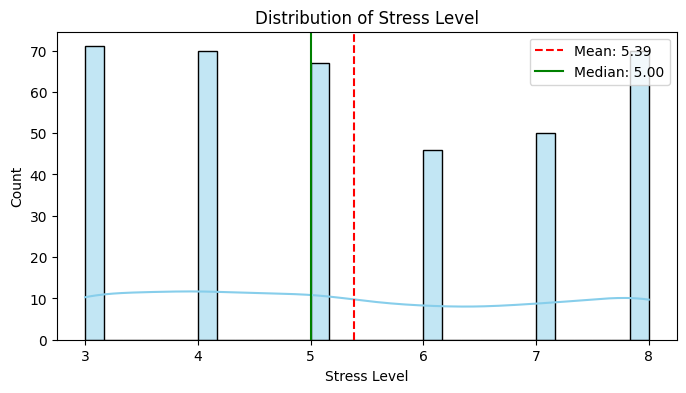

Stress Level Mean: 5.39
Stress Level Median: 5.00
Stress Level Standard Deviation: 1.77


In [59]:

# 1. Distribution of Stress Level
# Histogram of Target Variable with Mean and Median Lines
plt.figure(figsize=(8, 4))
sns.histplot(df[target], kde=True, bins=30, color='skyblue')
plt.title(f"Distribution of {target}")

mean_val = df[target].mean()
median_val = df[target].median()

plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

print(f"{target} Mean: {mean_val:.2f}")
print(f"{target} Median: {median_val:.2f}")
print(f"{target} Standard Deviation: {df[target].std():.2f}")


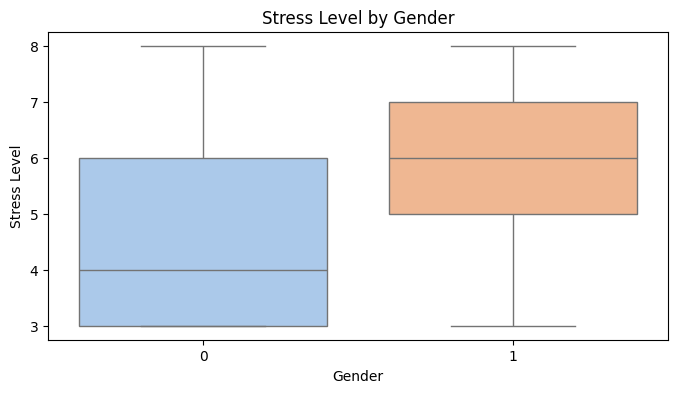

In [60]:
# 2. Gender vs Stress Level
plt.figure(figsize=(8, 4))
sns.boxplot(x='Gender', y='Stress Level', data=df, palette='pastel')
plt.title('Stress Level by Gender')
plt.show()


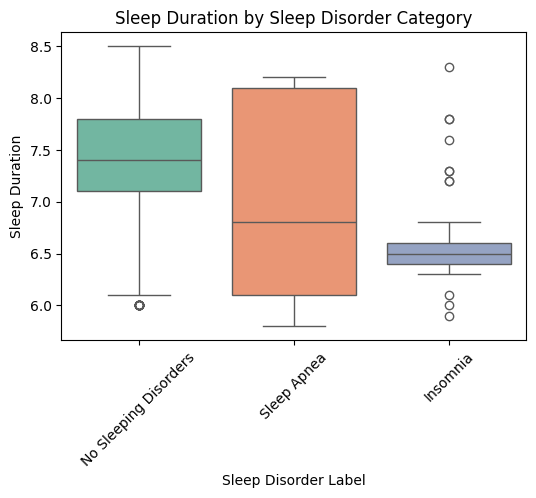

                       count      mean       std  min  25%  50%  75%  max
Sleep Disorder Label                                                     
Insomnia                77.0  6.589610  0.387157  5.9  6.4  6.5  6.6  8.3
No Sleeping Disorders  219.0  7.358447  0.732320  6.0  7.1  7.4  7.8  8.5
Sleep Apnea             78.0  7.032051  0.974812  5.8  6.1  6.8  8.1  8.2 



In [61]:
# 3. Sleep Duration across Sleep Disorder categories
# Decode back to original category names for plotting
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Plot using the decoded labels
plt.figure(figsize=(6, 4))
sns.boxplot(x='Sleep Disorder Label', y='Sleep Duration', data=df, palette='Set2')
plt.title('Sleep Duration by Sleep Disorder Category')
plt.xticks(rotation=45)
plt.show()

# Grouped statistics by decoded labels
print(df.groupby('Sleep Disorder Label')['Sleep Duration'].describe(), "\n")


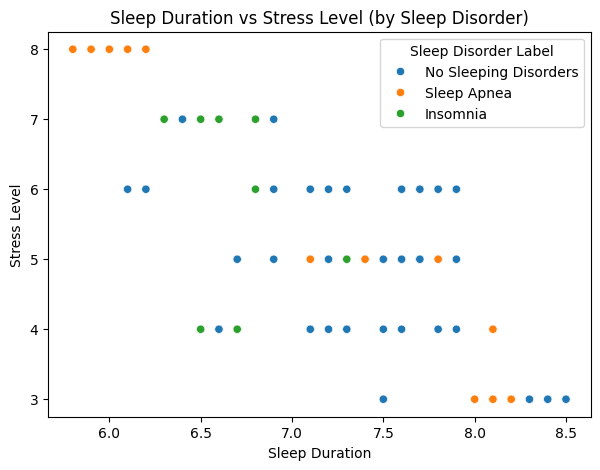

In [62]:
# 4. Scatter plot: Sleep Duration vs Stress Level
# Decode encoded labels back to original
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Now plot using the decoded labels
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Sleep Duration', y='Stress Level', hue='Sleep Disorder Label', data=df)
plt.title('Sleep Duration vs Stress Level (by Sleep Disorder)')
plt.show()


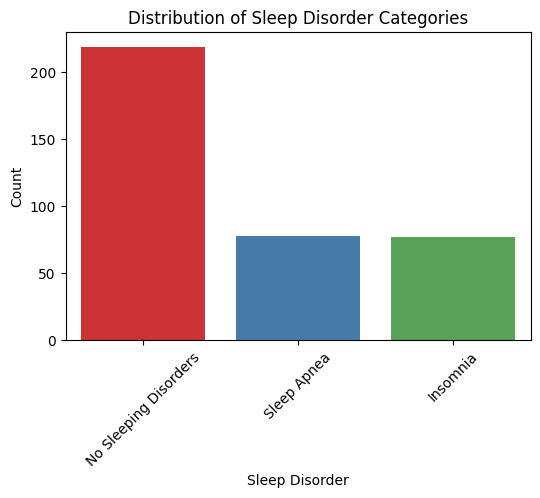

Sleep Disorder Label
No Sleeping Disorders    219
Sleep Apnea               78
Insomnia                  77
Name: count, dtype: int64


In [63]:
# 5. Count Plot: Sleep Disorder Distribution
# Decode back to original sleep disorder names
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Plot using the decoded labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sleep Disorder Label', palette='Set1')
plt.title('Distribution of Sleep Disorder Categories')
plt.xlabel('Sleep Disorder')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Show counts of each sleep disorder category
counts = df['Sleep Disorder Label'].value_counts()
print(counts)


FEATURE SELECTION METHODS

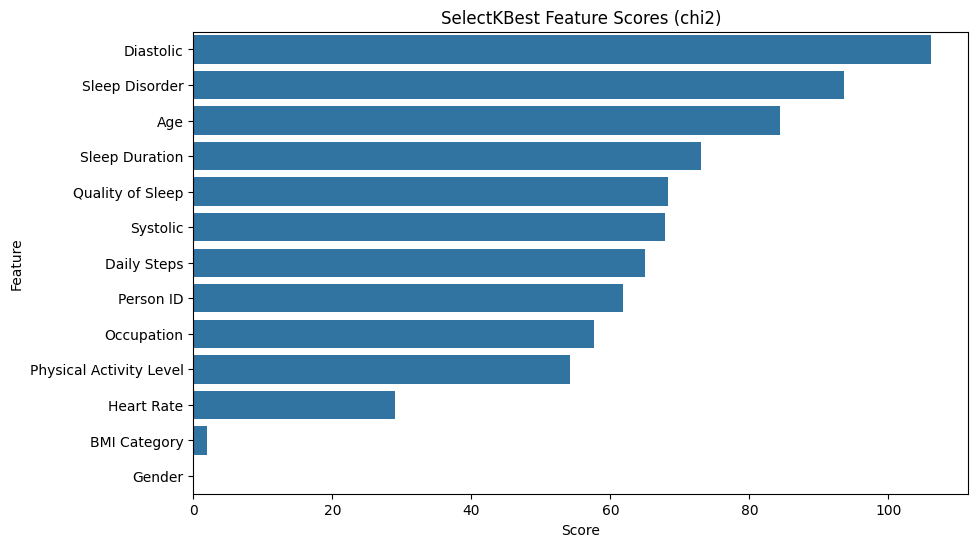


SelectKBest Feature Scores:
                    Feature       Score
12                Diastolic  106.186589
10           Sleep Disorder   93.616783
2                       Age   84.401550
4            Sleep Duration   72.973141
5          Quality of Sleep   68.283872
11                 Systolic   67.837643
9               Daily Steps   64.949159
0                 Person ID   61.891454
3                Occupation   57.700970
6   Physical Activity Level   54.265375
8                Heart Rate   28.985051
7              BMI Category    2.022354
1                    Gender    0.021090


In [64]:

# Feature 1. SelectKBest with chi2
kbest = SelectKBest(score_func=chi2, k='all')
kbest.fit(X_scaled.abs(), y)

feature_scores = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Score': kbest.scores_
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title("SelectKBest Feature Scores (chi2)")
plt.show()

print("\nSelectKBest Feature Scores:")
print(feature_scores)



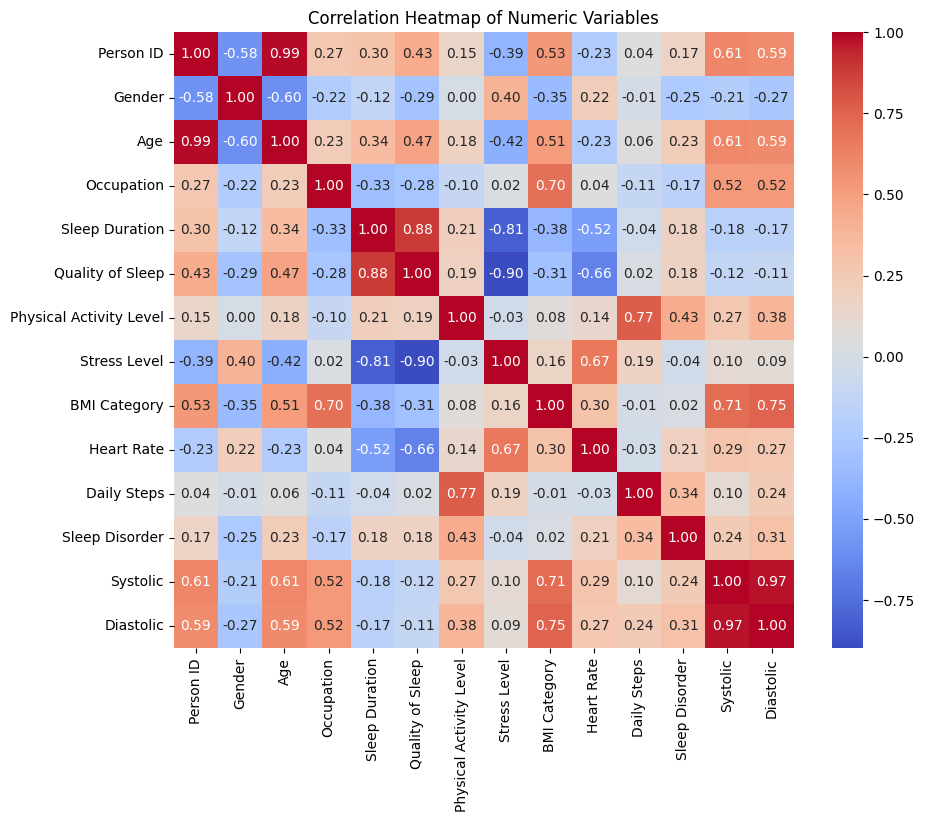

In [65]:
# Feature 2:Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()



MODEL 1: LOGISTIC REGRESSION

In [66]:
# Importing necessary libraries
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [67]:
# Define Features and Split Data
features = ['Diastolic', 'Sleep Duration', 'Quality of Sleep', 'Heart Rate','Sleep Disorder', 'Age', 'Systolic']
target = 'Stress Level'

X = df[features]
y = df[target]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

HYPERTUNING METHOD:GRIDSEARCH + EARLY STOPPING

In [68]:
# Grid Search for eta0
eta_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

best_eta = None
best_val_loss_eta = float("inf")
print("\nGrid Search for eta0...")

for eta in eta_values:
    val_losses = []
    for train_idx, val_idx in skf.split(X_trainval_scaled, y_trainval):
        X_train_fold, X_val_fold = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=eta,
                            max_iter=100, warm_start=True, random_state=40)

        clf.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y))
        min_val_loss, no_improve = float("inf"), 0

        for epoch in range(100):
            clf.partial_fit(X_train_fold, y_train_fold)
            y_val_prob = clf.predict_proba(X_val_fold)
            val_loss = log_loss(y_val_fold, y_val_prob)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= 7:
                break

        val_losses.append(min_val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"eta0={eta} | Avg Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss_eta:
        best_val_loss_eta = avg_val_loss
        best_eta = eta

print(f"\nBest eta0: {best_eta} with Avg Val Loss: {best_val_loss_eta:.4f}")



Grid Search for eta0...
eta0=0.0001 | Avg Val Loss: 1.4064
eta0=0.0005 | Avg Val Loss: 0.9863
eta0=0.001 | Avg Val Loss: 0.8084
eta0=0.005 | Avg Val Loss: 0.5763
eta0=0.01 | Avg Val Loss: 0.5322
eta0=0.05 | Avg Val Loss: 0.4797
eta0=0.1 | Avg Val Loss: 0.4717

Best eta0: 0.1 with Avg Val Loss: 0.4717


In [69]:
# Grid Search for alpha

alpha_values = [0.0001, 0.001, 0.01, 0.1]
best_alpha = None
best_val_loss_alpha = float("inf")
print("\nGrid Search for alpha...")

for alpha in alpha_values:
    val_losses = []
    for train_idx, val_idx in skf.split(X_trainval_scaled, y_trainval):
        X_train_fold, X_val_fold = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=best_eta, alpha=alpha,
                            max_iter=100, warm_start=True, random_state=40)

        clf.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y))
        min_val_loss, no_improve = float("inf"), 0

        for epoch in range(100):
            clf.partial_fit(X_train_fold, y_train_fold)
            y_val_prob = clf.predict_proba(X_val_fold)
            val_loss = log_loss(y_val_fold, y_val_prob)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
            if no_improve >= 7:
                break

        val_losses.append(min_val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"alpha={alpha} | Avg Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss_alpha:
        best_val_loss_alpha = avg_val_loss
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha} with Avg Val Loss: {best_val_loss_alpha:.4f}")



Grid Search for alpha...
alpha=0.0001 | Avg Val Loss: 0.4717
alpha=0.001 | Avg Val Loss: 0.4893
alpha=0.01 | Avg Val Loss: 0.6156
alpha=0.1 | Avg Val Loss: 0.9635

Best alpha: 0.0001 with Avg Val Loss: 0.4717


In [70]:
# Grid Search for penalty
penalty_values = ['l1', 'l2', 'elasticnet']
best_penalty = None
best_val_loss_penalty = float("inf")
print("\nGrid Search for penalty...")

for penalty in penalty_values:
    val_losses = []
    for train_idx, val_idx in skf.split(X_trainval_scaled, y_trainval):
        X_train_fold, X_val_fold = X_trainval_scaled[train_idx], X_trainval_scaled[val_idx]
        y_train_fold, y_val_fold = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

        clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=best_eta,
                            alpha=best_alpha, penalty=penalty, max_iter=100,
                            warm_start=True, random_state=40)

        clf.partial_fit(X_train_fold, y_train_fold, classes=np.unique(y))
        min_val_loss, no_improve = float("inf"), 0

        for epoch in range(100):
            clf.partial_fit(X_train_fold, y_train_fold)
            y_val_prob = clf.predict_proba(X_val_fold)
            val_loss = log_loss(y_val_fold, y_val_prob)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
            if no_improve >= 7:
                break

        val_losses.append(min_val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"penalty={penalty} | Avg Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss_penalty:
        best_val_loss_penalty = avg_val_loss
        best_penalty = penalty

print(f"\nBest penalty: {best_penalty} with Avg Val Loss: {best_val_loss_penalty:.4f}")



Grid Search for penalty...
penalty=l1 | Avg Val Loss: 0.4716
penalty=l2 | Avg Val Loss: 0.4717
penalty=elasticnet | Avg Val Loss: 0.4717

Best penalty: l1 with Avg Val Loss: 0.4716


In [71]:
# Final Training with Early Stopping
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_trainval)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_trainval)
class_weights = dict(zip(classes, weights))

clf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=best_eta,
                    alpha=best_alpha, penalty=best_penalty,
                    max_iter=100, class_weight=class_weights,  warm_start=True, random_state=40)

clf.partial_fit(X_trainval_scaled, y_trainval, classes=classes)

train_loss, test_loss = [], []
train_acc, test_acc = [], []
no_improve = 0
best_loss = float("inf")
patience = 7
epochs = 100

for epoch in range(epochs):
    clf.partial_fit(X_trainval_scaled, y_trainval)

    y_train_pred = clf.predict(X_trainval_scaled)
    y_test_pred = clf.predict(X_test_scaled)
    y_train_prob = clf.predict_proba(X_trainval_scaled)
    y_test_prob = clf.predict_proba(X_test_scaled)

    loss_train = log_loss(y_trainval, y_train_prob)
    loss_test = log_loss(y_test, y_test_prob)
    acc_train = accuracy_score(y_trainval, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    train_loss.append(loss_train)
    test_loss.append(loss_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)

    print(f"Epoch {epoch+1:03d} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f} | Train Loss: {loss_train:.4f} | Test Loss: {loss_test:.4f}")

    if loss_test < best_loss:
        best_loss = loss_test
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 001 | Train Acc: 0.8829 | Test Acc: 0.9067 | Train Loss: 0.6162 | Test Loss: 0.6249
Epoch 002 | Train Acc: 0.8863 | Test Acc: 0.9067 | Train Loss: 0.5635 | Test Loss: 0.5791
Epoch 003 | Train Acc: 0.8930 | Test Acc: 0.9067 | Train Loss: 0.5322 | Test Loss: 0.5550
Epoch 004 | Train Acc: 0.8930 | Test Acc: 0.9067 | Train Loss: 0.5106 | Test Loss: 0.5400
Epoch 005 | Train Acc: 0.8930 | Test Acc: 0.9067 | Train Loss: 0.4943 | Test Loss: 0.5294
Epoch 006 | Train Acc: 0.8930 | Test Acc: 0.9067 | Train Loss: 0.4814 | Test Loss: 0.5215
Epoch 007 | Train Acc: 0.8963 | Test Acc: 0.9067 | Train Loss: 0.4707 | Test Loss: 0.5153
Epoch 008 | Train Acc: 0.8997 | Test Acc: 0.9200 | Train Loss: 0.4617 | Test Loss: 0.5102
Epoch 009 | Train Acc: 0.8997 | Test Acc: 0.9200 | Train Loss: 0.4539 | Test Loss: 0.5060
Epoch 010 | Train Acc: 0.9064 | Test Acc: 0.9200 | Train Loss: 0.4471 | Test Loss: 0.5024
Epoch 011 | Train Acc: 0.9064 | Test Acc: 0.9200 | Train Loss: 0.4410 | Test Loss: 0.4994
Epoch 012 

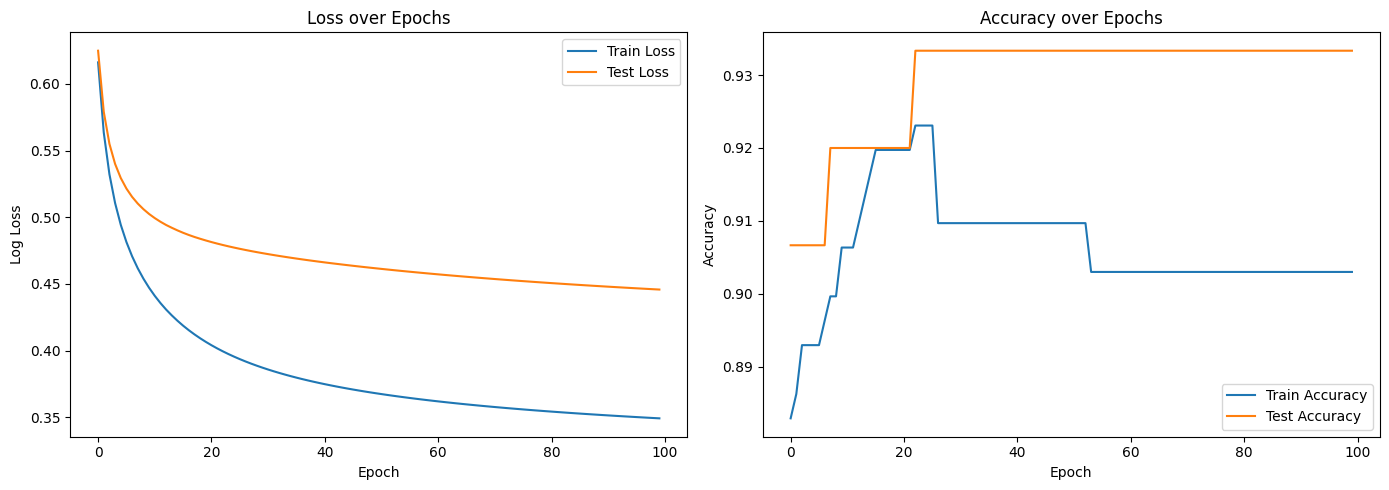

In [72]:
# Plot Learning Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

FINAL RESULTS AND PLOTS OF THE MODEL

 Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.86      0.92        14
           4       0.88      1.00      0.93        14
           5       0.93      1.00      0.97        14
           6       0.80      0.89      0.84         9
           7       1.00      0.80      0.89        10
           8       1.00      1.00      1.00        14

    accuracy                           0.93        75
   macro avg       0.93      0.92      0.93        75
weighted avg       0.94      0.93      0.93        75



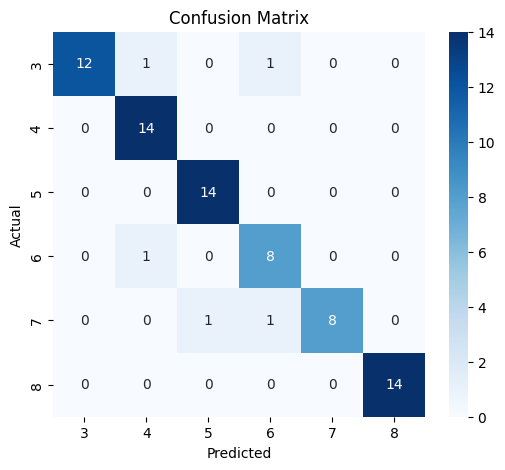

In [73]:
# FINAL PREDICTIONS
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)

# CLASSIFICATION REPORT
print(" Classification Report:")
print(classification_report(y_test, y_pred))

# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

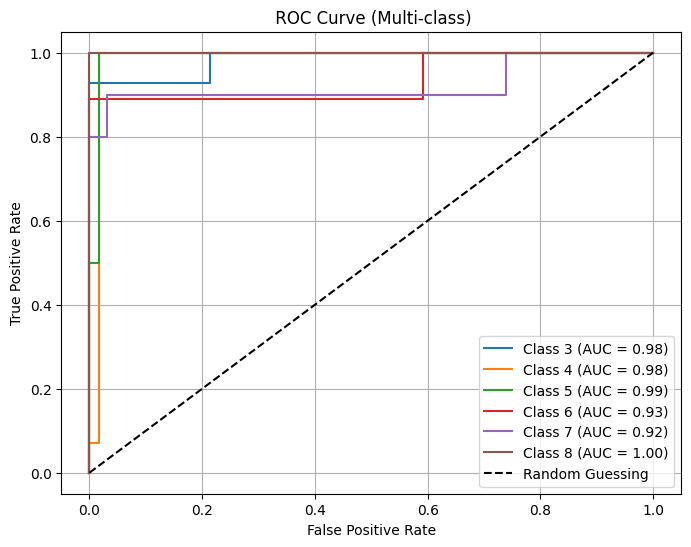

 Overall AUC Score: 0.97


In [74]:
# ROC CURVE

# Binarize output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=classes)
y_prob_bin = y_prob
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {np.unique(y)[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title(' ROC Curve (Multi-class)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Overall AUC Score
overall_auc = roc_auc_score(y_test_bin, y_prob_bin, multi_class='ovr')
print(f" Overall AUC Score: {overall_auc:.2f}")